In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

sns.set_style("whitegrid")

In [3]:
train_data = pd.read_csv('regression/train_reg.csv')
test_data = pd.read_csv('regression/test_reg.csv')

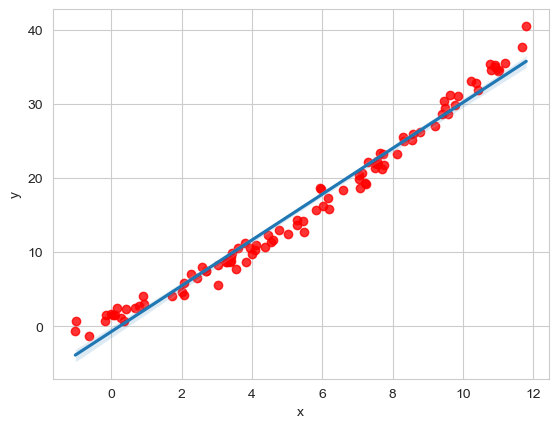

In [4]:
ax = sns.regplot(x = 'x' , y = 'y', data = train_data, fit_reg= True, scatter_kws= {'color':'red'})

In [5]:
X_train = train_data[['x']]
y_train = train_data[['y']]
X_test = test_data[['x']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.Normal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_train)
    trace_g = pm.sample(3000, tune=2000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 34 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

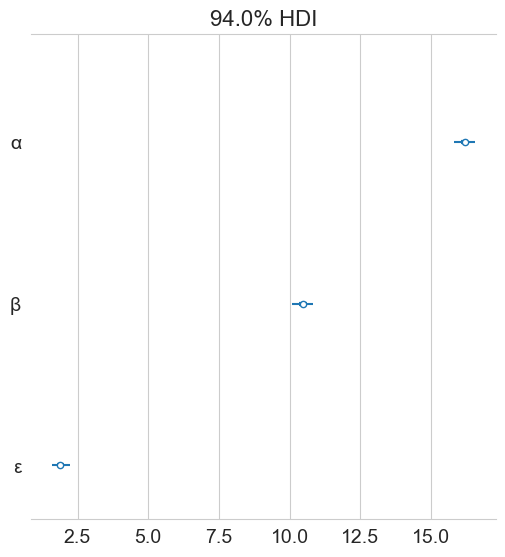

In [7]:
az.plot_forest(trace_g, var_names=['α', 'β', 'ε'], combined=True)

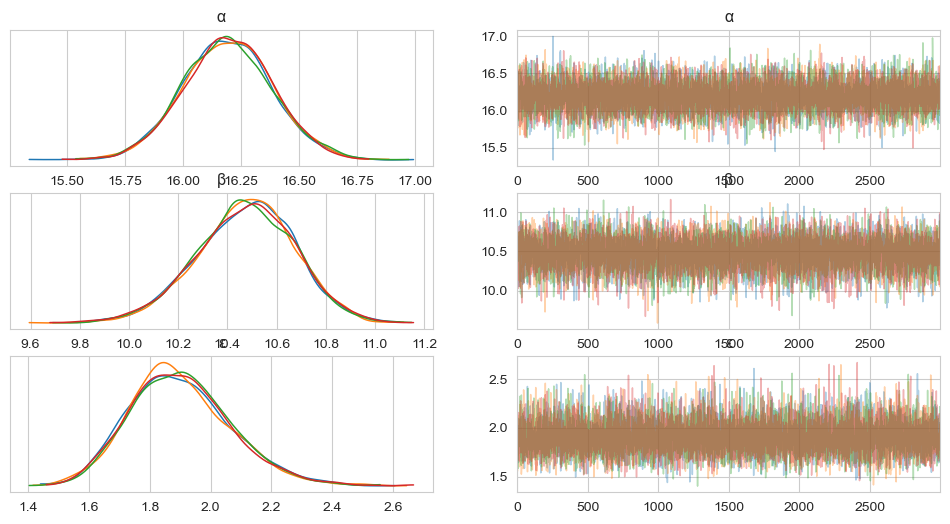

In [8]:
az.plot_trace(trace_g, var_names=['α', 'β', 'ε'], compact= False);

In [9]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,16.192,0.193,15.826,16.555,0.002,0.001,14657.0,8521.0,1.0
β,10.474,0.199,10.095,10.845,0.002,0.001,10893.0,8468.0,1.0
ε,1.902,0.168,1.599,2.220,0.002,0.001,11636.0,8530.0,1.0
"μ[0, 0]",1.099,0.344,0.458,1.742,0.003,0.002,11877.0,8843.0,1.0
"μ[1, 0]",6.053,0.271,5.561,6.579,0.002,0.002,12544.0,9230.0,1.0
...,...,...,...,...,...,...,...,...,...
"μ[95, 0]",21.355,0.217,20.962,21.778,0.002,0.001,13583.0,8320.0,1.0
"μ[96, 0]",-0.658,0.372,-1.346,0.045,0.003,0.002,11734.0,9044.0,1.0
"μ[97, 0]",10.062,0.224,9.653,10.494,0.002,0.001,13443.0,8759.0,1.0
"μ[98, 0]",28.128,0.300,27.573,28.698,0.003,0.002,12110.0,8593.0,1.0


всего трасс :  12000


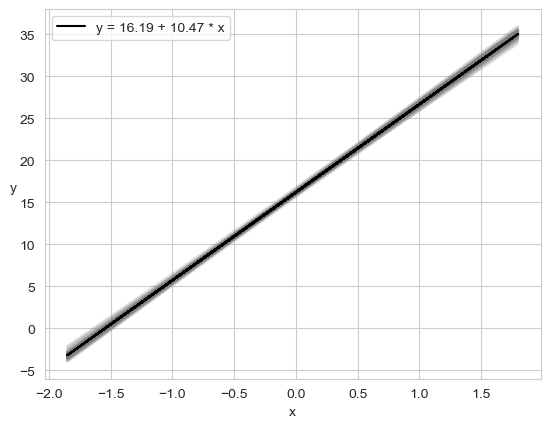

In [10]:
posterior_g = az.extract(trace_g)

alpha_m = posterior_g['α'].mean().item()
beta_m  = posterior_g['β'].mean().item()

print("всего трасс : ", posterior_g.sample.size)

draws = range(0, posterior_g.sample.size, 100)

plt.plot(X_train, posterior_g['α'][draws].values + posterior_g['β'][draws].values * X_train, c='gray', alpha=0.1)

plt.plot(X_train, alpha_m + beta_m * X_train, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

In [11]:
у_pred = alpha_m + beta_m*X_test

In [12]:
у_pred = у_pred.reshape(100)
у_pred

array([17.48124718,  7.78029193, -2.12468074, 29.33289364, 21.38601435,
       21.93153188, 12.98732235, 25.12037664, 27.76626159,  5.93043275,
        6.6061453 , 28.09564942, 21.60279375,  9.94446056, 28.06333918,
       29.89441395, 17.70384371, 24.1495403 , 17.45799438,  5.46655188,
       24.46199404,  7.62288067, 23.94399987, 20.93250077, 10.82616969,
        8.18009717, 14.08166755, 14.05112884, 21.49874128, 23.86151702,
        2.36571191,  1.83493697,  8.70216477, 11.52738809, 21.10008976,
       21.00699686, 21.50407399, 20.58839509, 28.35077552,  6.81683589,
        7.99563832, 37.89530833,  8.60143351,  1.66801133, 20.62172968,
       33.258285  ,  2.97307052,  1.81110127, 25.07762403, 15.55147265,
       17.7371591 , 24.90549931, -0.45566585, 21.03144864, 11.19602831,
       12.24220998, 20.26744053, 18.21582857, 29.14743395, 14.49292216,
       27.82298834, 17.07873106,  3.19875371,  2.3036054 ,  6.91569386,
       13.59447675,  4.60181044, 33.70929067, 15.60517047, 22.70

In [14]:
from sklearn.metrics import mean_squared_error
y_true = pd.read_csv('test_Y_true_reg.csv')
mean_squared_error(y_true, у_pred)

2.56182589722706